<a href="https://colab.research.google.com/github/danphan/adversarial_mnist/blob/main/mnist_adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time
import random

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

Create Training Pipeline

In [ ]:
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE) #apply normalize_img to all of the data
ds_train = ds_train.cache() #store data in cache so that it can be loaded faster
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples) #make sure to shuffle data for randomness. tell shuffle method the size of the dataset to ensure randomness
ds_train = ds_train.batch(128) #make batch size power of 2 for efficiency
ds_train = ds_train.prefetch(tf.data.AUTOTUNE) #preprocess next batch while performing current training step

Create Evaluation Pipeline

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls = tf.data.AUTOTUNE)
ds_test = ds_test.cache()
#no need for shuffling during evaluation. we are not doing any gradient descent here.
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Create Basic Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(10)
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    epochs = 20,
    validation_data = ds_test
)

Epoch 1/20
469/469 [==============================] - 11s 8ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8996 - val_loss: 0.2012 - val_sparse_categorical_accuracy: 0.9412
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.1725 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.1475 - val_sparse_categorical_accuracy: 0.9570
Epoch 3/20
469/469 [==============================] - 3s 5ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.1123 - val_sparse_categorical_accuracy: 0.9645
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0961 - val_sparse_categorical_accuracy: 0.9699
Epoch 5/20
469/469 [==============================] - 3s 5ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.0875 - val_sparse_categorical_accuracy: 0.9735
Epoch 6/20
469/469 [==============================] - 3s 5ms/step - loss: 0.0644 - sparse_categoric

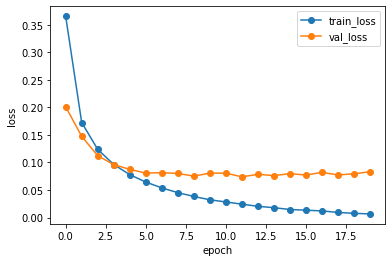

In [ ]:
plt.plot(history.history['loss'], 'o-', label = 'train_loss')
plt.plot(history.history['val_loss'], 'o-', label = 'val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend();

Let's look at a few images, and their labels:

Predicted: 2
Actual: 2


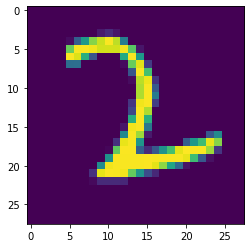

In [ ]:
for x in ds_train:
  imgs, labels = x
  break

img_idx = 0
preds = model(imgs)
probs_pred = tf.nn.softmax(preds)
print('Predicted:',tf.math.argmax(probs_pred[img_idx]).numpy())
print('Actual:',labels[img_idx].numpy())
plt.imshow(imgs[img_idx, :,:,0])
plt.show()

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, imgs)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

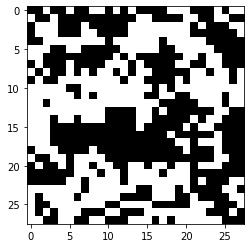

In [ ]:
# Get the input label of the image.
#label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(imgs, labels)
plt.imshow(perturbations[img_idx], cmap = 'gray')
plt.show()
#plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


In [ ]:
def display_images(image, description = 'hi', idx = 0):
  image = tf.expand_dims(image, axis = 0)
  model_pred = model.predict(image)
  model_prob = tf.nn.softmax(model_pred)
  label_pred = tf.math.argmax(model_prob, axis = 1)
  confidence = []
  for i in range(label_pred.shape[0]):
    confidence.append(model_prob[i, label_pred[i]])

  plt.figure()
  plt.imshow(image[0]) #show idx'th image
  plt.title('{} \n {} : {}% Confidence'.format(description,
                                                   label_pred[idx], confidence[idx]*100))
  plt.show()


1/1 [==============================] - 0s 72ms/step


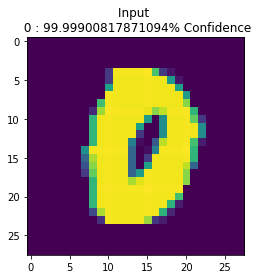

1/1 [==============================] - 0s 25ms/step


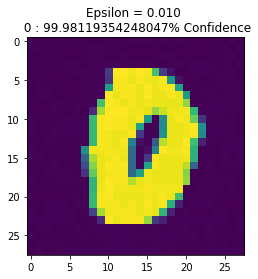

1/1 [==============================] - 0s 26ms/step


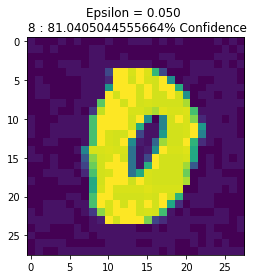

1/1 [==============================] - 0s 28ms/step


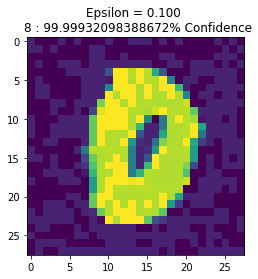

In [ ]:
epsilons = [0, 0.01, 0.05, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = imgs + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x[100], descriptions[i])


Evaluate Accuracy on adversarially-perturbed test set

In [ ]:
class Adversary:
  def __init__(self, model, img_modifier = None):
    self.model = model 
    self.img_modifier = img_modifier

  def adversarial_accuracy(self, data):
    num_correct = 0
    num_instances = 0

    for img, label in data:
      #modify image
      img_modified = self.img_modifier(self.model, img, label)

      model_out = self.model(img_modified)
      model_prob = tf.nn.softmax(model_out)
      model_pred = tf.math.argmax(model_prob, axis = -1)
      equals = tf.cast(model_pred == label, dtype = tf.float64)
      num_correct += tf.math.reduce_sum(equals).numpy()
      num_instances += len(img)
    return num_correct/num_instances

def fast_gradient_sign_method(epsilon, model, img, label):
  with tf.GradientTape() as tape:
    tape.watch(img)
    prediction = model(img)
    loss = loss_object(label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, img)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return tf.clip_by_value(img + epsilon * signed_grad, 0, 1)


Apply Fast-Gradient-Sign method to test set

In [ ]:
for eps in [0,0.01,0.05,0.1]:
  t1 = time.time()
  adv = Adversary(model, lambda model, img, label: fast_gradient_sign_method(eps, model, img, label))
  adv_acc = adv.adversarial_accuracy(ds_test)
  t2 = time.time()
  print(f'Epsilon: {eps}')
  print(f'Accuracy: {adv_acc}')
  print(f'Time to obtain adversarial accuracy: {t2-t1}seconds\n')

Epsilon: 0
Accuracy: 0.9788
Time to obtain adversarial accuracy: 2.55361008644104seconds

Epsilon: 0.01
Accuracy: 0.9495
Time to obtain adversarial accuracy: 1.3001022338867188seconds

Epsilon: 0.05
Accuracy: 0.3928
Time to obtain adversarial accuracy: 1.2586054801940918seconds

Epsilon: 0.1
Accuracy: 0.1198
Time to obtain adversarial accuracy: 2.547677516937256seconds



Let's implement the Projected Gradient Descent attack. The idea behind PGD is that we want to find the perturbation $\delta$ which maximizes the loss $l(x+\delta, y)$, where $x$ is the image and $y$ is the correct class. However, we will restrict $\delta$ to be small. This means that we will restrict the norm of $\delta$, $|\delta| < \epsilon$, where $\epsilon$ is any number we want. We can also use whatever norm we want. Here, we will use the $L_\infty$ norm.

To this end, we will simply perform gradient ascent, with some learning rate $\eta$, for some number of iterations $N$. At each gradient ascent step, we will clip $\delta$ such that its norm does not exceed $\epsilon$.

We will for now make this an untargeted attack (i.e. we will not try to make the network guess a specific guess.

In [ ]:
def pgd(model, img, label, epsilon = 1e-2, lr = 1e-2, num_iter = 10):
  delta = tf.random.uniform(tf.shape(img), minval = -epsilon, maxval = epsilon)
  img_mod = img + delta
  for i in range(num_iter):
    with tf.GradientTape() as tape:
      tape.watch(img_mod)
      prediction = model(img_mod)
      loss = loss_object(label, prediction)
    grad = tape.gradient(loss, img_mod)
    delta += lr * tf.sign(grad) #take the sign of the gradient, similar to the fast-gradient-sign-method
    delta  = tf.clip_by_value(delta, -epsilon, epsilon)
    img_mod = tf.clip_by_value(img + delta, 0, 1)
  return img_mod

Let's try this projected gradient descent (ascent) method and see how it affects the accuracy

In [ ]:
for eps in [0,0.01,0.05,0.1]:
  t1 = time.time()
  adv = Adversary(model, lambda model, img, label: pgd(model, img, label, epsilon = eps, lr = eps/3, num_iter = 20))
  adv_acc = adv.adversarial_accuracy(ds_test)
  t2 = time.time()
  print(f'Epsilon: {eps}')
  print(f'Accuracy: {adv_acc}')
  print(f'Time to obtain adversarial accuracy: {t2-t1}seconds\n')

Epsilon: 0
Accuracy: 0.9788
Time to obtain adversarial accuracy: 40.955418825149536seconds

Epsilon: 0.01
Accuracy: 0.9489
Time to obtain adversarial accuracy: 21.361084699630737seconds

Epsilon: 0.05
Accuracy: 0.3242
Time to obtain adversarial accuracy: 40.94659161567688seconds

Epsilon: 0.1
Accuracy: 0.0139
Time to obtain adversarial accuracy: 21.374633312225342seconds



Let's try to create a model that's robust against PGD, by fine-tuning.

For a benchmark, let's evaluate the accuracy of our initial model on the test set.

In [ ]:
loss, acc = model.evaluate(ds_test)

eps = 5e-2
num_iter = 20

t1 = time.time()
adv = Adversary(model, lambda model, img, label: pgd(model, img, label, epsilon = eps, lr = eps/3, num_iter = num_iter))
adv_acc = adv.adversarial_accuracy(ds_test)
t2 = time.time()

print(f'Accuracy: {acc}')
print(f'Adversarial accuracy: {adv_acc}')
print(f'Time to obtain adversarial accuracy: {t2-t1}seconds\n')


79/79 [==============================] - 0s 3ms/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9788
Accuracy: 0.9787999987602234
Adversarial accuracy: 0.3241
Time to obtain adversarial accuracy: 21.482336044311523seconds



Now, we will fine-tune this model in two ways:

1. Perform vanilla SGD on this model, first modifying each batch using the PGD attack.
2. Perform vanilla SGD on this model, first modifying each batch using the PGD attack, but with a modified learning rate schedule.

We can compare these to a model with the same architecture, but which is trained from scratch on the adversarial data.

In [ ]:
class AdvTrainedModel(tf.keras.Model):
    def __init__(self, inputs, outputs, img_modifier):
        
        super().__init__(inputs, outputs)
        self.img_modifier = img_modifier
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        #apply adversarial attack to x
        x_adv = self.img_modifier(lambda u: self(u), x, y)

        with tf.GradientTape() as tape:
            y_pred = self(x_adv, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


Use PGD during training to modify each batch. Train model from scratch.

In [ ]:
inputs = tf.keras.Input((28,28))
hidden = tf.keras.layers.Dense(128,activation = 'relu')(tf.keras.layers.Flatten()(inputs))
outputs = tf.keras.layers.Dense(10)(hidden)

model_benchmark = AdvTrainedModel(inputs = inputs, outputs = outputs, img_modifier = lambda model, x, y: pgd(model, x, y, epsilon = eps, lr = eps/3, num_iter = 20))
model_benchmark.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model_benchmark.fit(
    ds_train,
    epochs = 20,
    validation_data = ds_test
)


Epoch 1/20
469/469 [==============================] - 29s 49ms/step - loss: 0.7615 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.2562 - val_sparse_categorical_accuracy: 0.9291
Epoch 2/20
469/469 [==============================] - 23s 49ms/step - loss: 0.4736 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.1817 - val_sparse_categorical_accuracy: 0.9522
Epoch 3/20
469/469 [==============================] - 22s 46ms/step - loss: 0.3910 - sparse_categorical_accuracy: 0.8790 - val_loss: 0.1538 - val_sparse_categorical_accuracy: 0.9574
Epoch 4/20
469/469 [==============================] - 23s 49ms/step - loss: 0.3413 - sparse_categorical_accuracy: 0.8947 - val_loss: 0.1286 - val_sparse_categorical_accuracy: 0.9624
Epoch 5/20
469/469 [==============================] - 22s 48ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.1101 - val_sparse_categorical_accuracy: 0.9690
Epoch 6/20
469/469 [==============================] - 23s 48ms/step - loss: 0.2830 - spars

Now, let's fine-tune our original model, going only for 5 epochs.

In [ ]:
inputs = tf.keras.Input((28,28))
hidden = tf.keras.layers.Dense(128,activation = 'relu')(tf.keras.layers.Flatten()(inputs))
outputs = tf.keras.layers.Dense(10)(hidden)

model_fine_tuned = AdvTrainedModel(inputs = inputs, outputs = outputs, img_modifier = lambda model, x, y: pgd(model, x, y, epsilon = eps, lr = eps/3, num_iter = 20))

#initialize model with pretrained weights
model_fine_tuned.set_weights(model.get_weights())

model_fine_tuned.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model_fine_tuned.fit(
    ds_train,
    epochs = 5,
    validation_data = ds_test
)

Epoch 1/5
469/469 [==============================] - 68s 50ms/step - loss: 0.8523 - sparse_categorical_accuracy: 0.7861 - val_loss: 0.0814 - val_sparse_categorical_accuracy: 0.9793
Epoch 2/5
469/469 [==============================] - 25s 53ms/step - loss: 0.3601 - sparse_categorical_accuracy: 0.8895 - val_loss: 0.0701 - val_sparse_categorical_accuracy: 0.9797
Epoch 3/5
469/469 [==============================] - 23s 49ms/step - loss: 0.2732 - sparse_categorical_accuracy: 0.9105 - val_loss: 0.0666 - val_sparse_categorical_accuracy: 0.9816
Epoch 4/5
469/469 [==============================] - 23s 50ms/step - loss: 0.2319 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9809
Epoch 5/5
469/469 [==============================] - 25s 53ms/step - loss: 0.2081 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.0616 - val_sparse_categorical_accuracy: 0.9811


Now, let's fine-tune our original model again, but using a custom learning-rate schedule.

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr * (epoch+1)/4 #reaches peak (i.e. lr), at epoch = 3
  else:
    return lr * np.exp(3-epoch) #decays exponentially afterwards

custom_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

inputs = tf.keras.Input((28,28))
hidden = tf.keras.layers.Dense(128,activation = 'relu')(tf.keras.layers.Flatten()(inputs))
outputs = tf.keras.layers.Dense(10)(hidden)

model_custom_lr = AdvTrainedModel(inputs = inputs, outputs = outputs, img_modifier = lambda model, x, y: pgd(model, x, y, epsilon = eps, lr = eps/3, num_iter = 20))

#initialize model with pretrained weights
model_custom_lr.set_weights(model.get_weights())

model_custom_lr.compile(
    optimizer = tf.keras.optimizers.SGD(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
)

history = model_custom_lr.fit(
    ds_train,
    epochs = 5,
    validation_data = ds_test,
    callbacks = [custom_lr_scheduler]

)

Epoch 1/5
469/469 [==============================] - 28s 49ms/step - loss: 2.8294 - sparse_categorical_accuracy: 0.4480 - val_loss: 0.0977 - val_sparse_categorical_accuracy: 0.9760 - lr: 0.0025
Epoch 2/5
469/469 [==============================] - 23s 49ms/step - loss: 2.1979 - sparse_categorical_accuracy: 0.5378 - val_loss: 0.0975 - val_sparse_categorical_accuracy: 0.9755 - lr: 0.0012
Epoch 3/5
469/469 [==============================] - 22s 46ms/step - loss: 2.0174 - sparse_categorical_accuracy: 0.5651 - val_loss: 0.0980 - val_sparse_categorical_accuracy: 0.9753 - lr: 9.3750e-04
Epoch 4/5
469/469 [==============================] - 23s 49ms/step - loss: 1.8979 - sparse_categorical_accuracy: 0.5820 - val_loss: 0.0982 - val_sparse_categorical_accuracy: 0.9750 - lr: 9.3750e-04
Epoch 5/5
469/469 [==============================] - 23s 48ms/step - loss: 1.8265 - sparse_categorical_accuracy: 0.5931 - val_loss: 0.0979 - val_sparse_categorical_accuracy: 0.9749 - lr: 3.4489e-04


In [ ]:
def get_adv_acc(model, attacker):
  """
  attacker: callable, which takes in a model, img, and label and returns a modified img
  """
  t1 = time.time()
  adv = Adversary(model, lambda model, img, label: pgd(model, img, label, epsilon = eps, lr = eps/3, num_iter = 20))
  adv_acc = adv.adversarial_accuracy(ds_test)
  t2 = time.time()
  print(f'Adversarial Accuracy: {adv_acc}')
  print(f'Time to obtain adversarial accuracy: {t2-t1}seconds\n')

In [ ]:
model_fine_tuned.evaluate(ds_test)

79/79 [==============================] - 0s 5ms/step - loss: 0.0616 - sparse_categorical_accuracy: 0.9811


[0.061613038182258606, 0.9811000227928162]

Let's implement the DeepFool algorithm. Although it is an iterative algorithm which runs until the image is misclassified, we can stop after the first step and return the modified image.


In [ ]:
#try non-self-consistent stuff first
#first iteration of the deepfool algorithm
def deepfool(model, img, label):
  #calculate the gradient of f_k and f_k0
  with tf.GradientTape() as tape:
    tape.watch(img)
    prediction = model(img)
    #get class that each img was classified as
    idx_preds = tf.math.argmax(prediction, axis = -1)
    #get value of function for above classes
    f0 = tf.gather(prediction, idx_preds, axis = 1, batch_dims = 1)

    jacobian = tape.batch_jacobian(prediction, img)
  w0 = tf.gather(jacobian, idx_preds, axis = 1, batch_dims = 1)

  #distances are given by |f_k - f_k0|/|w_k - w_k0|
  distances_num = tf.math.abs(prediction - f0[:,tf.newaxis])
  distances_denom = tf.math.reduce_euclidean_norm(jacobian - tf.expand_dims(w0, axis = 1), axis = [-3,-2,-1]) #calculate euclidean norm over the image dimensions 

  distances = tf.math.divide_no_nan(distances_num, distances_denom) #make sure that there aren't any problems with dividing by zero

  #obtain closest classes which are not the ones predicted by the model
  #the first element is to ignore the "distance zero" classes, which are just the classes predicted by the model
  classes_closest = tf.argsort(distances, axis = -1, direction = 'ASCENDING')[:,1] 

  f_closest = tf.gather(prediction, classes_closest, axis = 1, batch_dims = 1)
  w_closest = tf.gather(jacobian, classes_closest, axis = 1, batch_dims = 1)

  perturbation = (tf.math.abs(f_closest-f0)/tf.math.reduce_euclidean_norm(w_closest-w0, axis = [-3,-2,-1])**2 )[:, tf.newaxis, tf.newaxis, tf.newaxis] * (w_closest - w0)
  
  return tf.clip_by_value(img + perturbation,0,1) 

#only take in a single image, which we will assume has shape [28,28,1]
def deepfool_scf(model, img, num_iter = 30, eta = 1e-4):

  img = tf.expand_dims(img, axis = 0) #add batch axis so model can evaluate img
  class_0 = tf.math.argmax(model(img), axis = -1)

  for i in range(num_iter):
    print(f'Iteration {i}')
    #calculate og label from model
    with tf.GradientTape() as tape:
      tape.watch(img)
      prediction = model(img)
      #get class that img was classified as
      class_0 = tf.math.argmax(prediction, axis = -1)

      #get value of f for the predicted class
      f0 = tf.gather(prediction, class_0, axis = 1, batch_dims = 1)

      jacobian = tape.batch_jacobian(prediction, img)
      w0 = tf.gather(jacobian, class_0, axis = 1, batch_dims = 1)

    distances_num = tf.math.abs(prediction - f0[:, tf.newaxis])
    distances_denom = tf.math.reduce_euclidean_norm(jacobian - tf.expand_dims(w0, axis = 1), axis = [-3,-2,-1]) #calculate euclidean norm over the image dimensions 

    distances = tf.math.divide_no_nan(distances_num, distances_denom) #make sure that there aren't any problems with dividing by zero

    #obtain closest class which is not the one predicted by the model
    #the first element in the second axis is to ignore the "distance zero" classes, which are just the classes predicted by the model
    classes_closest = tf.argsort(distances, axis = -1, direction = 'ASCENDING')[:,1] 

    f_closest = tf.gather(prediction, classes_closest, axis = 1, batch_dims = 1) #find value of loss for this closest class
    w_closest = tf.gather(jacobian, classes_closest, axis = 1, batch_dims = 1)   #find gradient for this closest class

    #find the perturbation which gets us to the decision boundary
    r = (1+eta)*(tf.math.abs(f_closest-f0)/tf.math.reduce_euclidean_norm(w_closest-w0, axis = [-3,-2,-1])**2 )[:, tf.newaxis, tf.newaxis, tf.newaxis] * (w_closest - w0)
    img = tf.clip_by_value(img + r,0,1) #make sure that the image exists within the correct bounds
    
    print('norm of modification: {}'.format(tf.norm(r)))
    #print('Norm of modified img: {}'.format(tf.norm(img_mod)))
    class_predict = tf.math.argmax(model(img), axis = -1)
    if class_predict != class_0:
      print('Network fooled')
      return img[0]

  return img[0]

In [ ]:
for x in ds_test:
  imgs_test, labels_test = x
  break

Iteration 0
norm of modification: 0.8033120632171631
Iteration 1
norm of modification: 0.13255852460861206
Iteration 2
norm of modification: 0.013370504602789879
Iteration 3
norm of modification: 0.0010997435310855508
Iteration 4
norm of modification: 9.04775079106912e-05
Iteration 5
norm of modification: 7.433169230353087e-06
Iteration 6
norm of modification: 6.702037467221089e-07
Network fooled
1/1 [==============================] - 0s 24ms/step


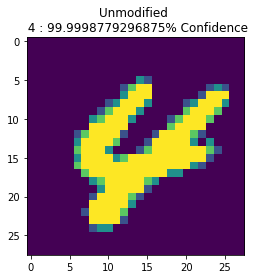

1/1 [==============================] - 0s 25ms/step


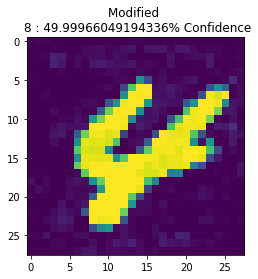

In [ ]:
img_unmod = imgs_test[15]
img_mod = deepfool_scf(model, img_unmod, eta = 3e-1)

display_images(img_unmod, 'Unmodified')
display_images(img_mod, 'Modified')

In [ ]:
t1 = time.time() 
adv = Adversary(model, deepfool)
adv_acc = adv.adversarial_accuracy(ds_test)
t2 = time.time()
print(f'Accuracy: {adv_acc}')
print(f'Time to obtain adversarial accuracy: {t2-t1}seconds\n')

Accuracy: 0.9785
Time to obtain adversarial accuracy: 21.51172399520874seconds



From the above, we see that the single-iteration deepfool algorithm decreases the accuracy on the **training set** from 99% to ~67%. That's pretty dramatic!

Now, let's implement the one-pixel attack algorithm.

In [ ]:
from scipy.optimize import differential_evolution, minimize

def modify_img(img, mod, batched = True):
  x, y, z = mod
  x = int(x)
  y = int(y)
  img_mod = tf.Variable(tf.identity(img))

  if batched:
    img_mod = img_mod[0,x,y,0].assign(z)
  else:
    img_mod = img_mod[x,y,0].assign(z)
  return img_mod

def one_pixel(model, img, target, mutation = 0.5, popsize = 20):

  img = tf.expand_dims(img, axis = 0)
  prediction = model(img)
  class_predicted = tf.math.argmax(prediction, axis = 1).numpy()
  if class_predicted == target:
    raise Exception('Image is already classified by model as target.')

  #return probability of target class
  #x and y can take integer values from 0 to 27 (inclusive), while z is a float between 0 and 1

  def func(input):
    img_mod = modify_img(img, input)
    prob =  tf.nn.softmax(model(img_mod))[0,target].numpy()
    # print(prob)
    return 1-prob #minus sign because we want to maximize this prob (i.e. minimize 1-prob)

  best_i = 0
  best_j = 0
  max_prob = 0

  for i in range(img.shape[1]):
    for j in range(img.shape[2]):
      opt = differential_evolution(lambda x: func([i,j,x]), bounds = [(0,1)], popsize = popsize, mutation = mutation)
#      opt = minimize(lambda x: func([i,j,x]), x0 = [0.5], bounds = [(0,1)], method = 'Nelder-Mead')
      prob = 1 - func([i,j,opt.x])
      if prob > max_prob:
        best_i, best_j, max_prob = i,j,prob
        print('New max prob: {} at pixel ({},{})'.format(max_prob,i,j))
      # print(f'Pixel ({i},{j}): {opt.x}')
      # print('Probability of target class: {}'.format(1-func([i,j,opt.x])))


  # opt = differential_evolution(func, bounds = [(0,27),(0,27),(0,1)],integrality = [True, True, False], popsize = popsize, mutation = mutation, polish = False, init = 'sobol')
  # print('Success? {}'.format(opt.success))
  # print('Reason for termination: {}'.format(opt.message))
  return [best_i, best_j, opt.x]


1/1 [==============================] - 0s 155ms/step


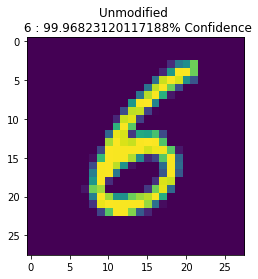

New max prob: 0.0003083453339058906 at pixel (0,0)
New max prob: 0.00039960138383321464 at pixel (0,1)
New max prob: 0.0004064769600518048 at pixel (0,25)
New max prob: 0.0005566824693232775 at pixel (1,14)
New max prob: 0.0005809491267427802 at pixel (2,18)
New max prob: 0.0008608853677287698 at pixel (3,4)
New max prob: 0.002992145949974656 at pixel (3,25)
New max prob: 0.007239848840981722 at pixel (4,25)
New max prob: 0.01254253275692463 at pixel (17,10)
[17, 10, array([0.00332741])]
1/1 [==============================] - 0s 32ms/step


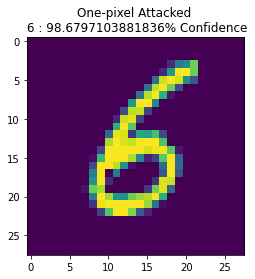

In [ ]:
img_unmod = imgs_test[100]
display_images(img_unmod, 'Unmodified')

#mod = one_pixel(model, img_unmod, target = 5)
mod = one_pixel(model, img_unmod, target = 5, mutation = (0.5,1.5), popsize = 20)
print(mod)
img_one_pixel = modify_img(img_unmod, mod, batched = False)

display_images(img_one_pixel, 'One-pixel Attacked')